<a href="https://colab.research.google.com/github/lizmosquera/InteligenciaComputacional/blob/master/20200510RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import tensorflow as tf
from math import sqrt

from numpy import concatenate

import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import torch
#from torch.autograd import Variable
import torch
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
print (tf.keras.__version__)
print (pd.__version__)

2.3.0-tf
1.0.3


In [29]:
df = pd.read_csv('Datos_TRM.csv', header=0, index_col=1)
#dataset.index = dataset['Date Time']
df.index.name = 'date'
df=df.drop(['Index','FF_EfcRate'], axis=1)
df.tail(5)

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
date,,,,,,,,,,,,,,,,
24/04/2020,4020.94,8.299271,0.03706,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,16.94,1735.6,-17.01,-0.004221,4008.944,3990.5985
27/04/2020,4039.87,8.303968,0.03675,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.78,1723.8,18.93,0.004697,4022.306,3988.2750
28/04/2020,4039.83,8.303958,0.03677,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.34,1722.2,-0.04,-0.000010,4036.720,3990.4750
29/04/2020,4046.04,8.305494,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,6.21,0.001536,4036.926,3990.6370
30/04/2020,3983.29,8.289863,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,-62.75,-0.015631,4025.994,3986.5610


In [0]:
Train=df.loc['30/01/2015':'8/01/2019']
Val=df.loc['9/01/2019':'31/12/2019']
Test=df.loc['2/01/2020':'10/01/2020']

In [52]:
Test

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
date,,,,,,,,,,,,,,,,
2/01/2020,3277.14,8.094726,0.04259,0.045902,0.055811,0.064531,0.010608,0.017666,0.024734,1.75,61.18,1540.1,0.00,0.000000,3287.114,3364.4640
3/01/2020,3258.84,8.089127,0.04260,0.044759,0.056100,0.064821,0.008447,0.018163,0.024892,1.75,63.05,1564.5,-18.30,-0.005600,3277.714,3352.0725
7/01/2020,3262.05,8.090111,0.04257,0.045015,0.055629,0.064423,0.008773,0.017659,0.024943,1.75,62.70,1586.3,3.21,0.000985,3273.844,3341.2465
8/01/2020,3264.26,8.090788,0.04254,0.044515,0.054818,0.063715,0.008803,0.017359,0.024996,1.75,59.61,1572.3,2.21,0.000677,3267.886,3331.4610
9/01/2020,3254.42,8.087769,0.04255,0.044411,0.054333,0.062871,0.009567,0.017183,0.024514,1.75,59.56,1566.4,-9.84,-0.003019,3263.342,3322.6665
10/01/2020,3253.89,8.087606,0.04256,0.044614,0.053886,0.062126,0.010061,0.017268,0.024438,1.75,59.04,1572.1,-0.53,-0.000163,3258.692,3314.4370


In [0]:
Train=Train.values
Train=Train.astype('float32')
Test=Test.values
Test=Test.astype('float32')
Val=Val.values
Val=Val.astype('float32')

In [54]:
scaler=StandardScaler()
Train_sc=scaler.fit_transform(Train)
Test_sc=scaler.transform(Test)
Val_sc=scaler.transform(Val)
Train_df=pd.DataFrame(Train_sc)
Test_df=pd.DataFrame(Test_sc)
Val_df=pd.DataFrame(Val_sc)
print(Train_df.shape)
print(Test_df.shape)
print(Val_df.shape)

(959, 16)
(6, 16)
(239, 16)


In [55]:
# split into input and outputs
train_X, train_y = Train_sc[:, :-1], Train_sc[:, -1]
test_X, test_y = Test_sc[:, :-1], Test_sc[:, -1]
val_X, val_y = Val_sc[:, :-1], Val_sc[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,val_X.shape,val_y.shape)

(959, 1, 15) (959,) (6, 1, 15) (6,) (239, 1, 15) (239,)


In [0]:
#conjunto de validación
validation_data = (np.expand_dims(val_X, axis=0),np.expand_dims(val_y, axis=0))

In [57]:
model_lstm=tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(32,return_sequences=True,
                                    input_shape=(train_X.shape[1],train_X.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=10,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=10))
model_lstm.add(tf.keras.layers.Dense(units=1))

model_lstm.compile(loss='mae',optimizer='adam')
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 1, 32)             6144      
_________________________________________________________________
lstm_25 (LSTM)               (None, 1, 10)             1720      
_________________________________________________________________
lstm_26 (LSTM)               (None, 10)                840       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 8,715
Trainable params: 8,715
Non-trainable params: 0
_________________________________________________________________


In [36]:
#fit network
history_lstm=model_lstm.fit(train_X,train_y,epochs=50,batch_size=5,
                            validation_data=(val_X,val_y),shuffle=False)

Epoch 1/50
192/192 [==============================] - 2s 10ms/step - loss: 0.6795 - val_loss: 1.6919
Epoch 2/50
192/192 [==============================] - 1s 5ms/step - loss: 0.5601 - val_loss: 1.2025
Epoch 3/50
192/192 [==============================] - 1s 4ms/step - loss: 0.4109 - val_loss: 1.1094
Epoch 4/50
192/192 [==============================] - 1s 4ms/step - loss: 0.3013 - val_loss: 1.0908
Epoch 5/50
192/192 [==============================] - 1s 4ms/step - loss: 0.2480 - val_loss: 1.0004
Epoch 6/50
192/192 [==============================] - 1s 5ms/step - loss: 0.2236 - val_loss: 0.9101
Epoch 7/50
192/192 [==============================] - 1s 4ms/step - loss: 0.2061 - val_loss: 0.8099
Epoch 8/50
192/192 [==============================] - 1s 5ms/step - loss: 0.1892 - val_loss: 0.8196
Epoch 9/50
192/192 [==============================] - 1s 5ms/step - loss: 0.1816 - val_loss: 0.8313
Epoch 10/50
192/192 [==============================] - 1s 5ms/step - loss: 0.1723 - val_loss: 0.781

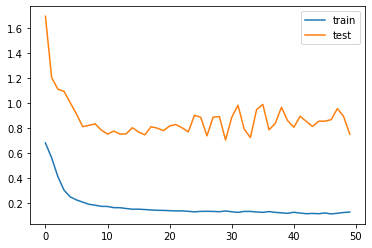

In [37]:
#plotting the training progression
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.show()

In [0]:
#make prediction
yhatt=model_lstm.predict(val_X)
xvalt=val_X.reshape((val_X.shape[0],val_X.shape[2]))

#invert scaling for forecast
inv_yhatt=concatenate((yhatt,xvalt),axis=1) #inv_yhat=concatenate((yhat,xtest[:,1:]),axis=1)
inv_yhatt=scaler.inverse_transform(inv_yhatt)
inv_yhatt=inv_yhatt[:,0]

#invert scaling for actual
yvalt=val_y.reshape((len(val_y),1))
inv_yt=concatenate((yvalt,xvalt),axis=1)#inv_y=concatenate((ytest,xtest[:,1:]),axis=1)
inv_yt=scaler.inverse_transform(inv_yt)
inv_yt=inv_yt[:,0]

In [60]:
print("Mean absolute error (MAE):       %f"% mean_absolute_error(inv_yt,inv_yhatt))
print("Mean squared error (MSE):        %f"% mean_squared_error(inv_yt,inv_yhatt))
print("Root Mean squared error (RMSE):  %f"% sqrt(mean_squared_error(inv_yt,inv_yhatt)))
print("R square (R^2):                  %f"% r2_score(inv_yt,inv_yhatt))

Mean absolute error (MAE):       348.136322
Mean squared error (MSE):        135807.953125
Root Mean squared error (RMSE):  368.521306
R square (R^2):                  -8.250523


<function matplotlib.pyplot.show>

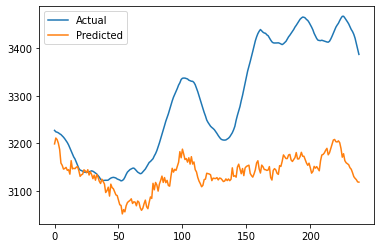

In [40]:
 plt.plot(inv_y,label='Actual')
 plt.plot(inv_yhat,label='Predicted')
 plt.legend()
 plt.show

**Predicción**

In [41]:
Train=df.loc['30/01/2015':'31/12/2019']
#Val=df.loc['9/01/2019':'31/12/2019'] 8/01/2019'
Test=df.loc['2/01/2020':'10/01/2020']
Train=Train.values
Train=Train.astype('float32')
Test=Test.values
Test=Test.astype('float32')

scaler=StandardScaler()
Train_sc=scaler.fit_transform(Train)
Test_sc=scaler.transform(Test)

Train_df=pd.DataFrame(Train_sc)
Test_df=pd.DataFrame(Test_sc)

print(Train_df.shape)
print(Test_df.shape)

# split into input and outputs
train_X, train_y = Train_sc[:, :-1], Train_sc[:, -1]
test_X, test_y = Test_sc[:, :-1], Test_sc[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1198, 16)
(6, 16)
(1198, 1, 15) (1198,) (6, 1, 15) (6,)


In [49]:
model_lstm=tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(32,return_sequences=True,
                                    input_shape=(train_X.shape[1],train_X.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=10,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=10))
model_lstm.add(tf.keras.layers.Dense(units=1))

model_lstm.compile(loss='mae',optimizer='adam')
model_lstm.summary()
#
#fit network
history_lstm=model_lstm.fit(train_X,train_y,epochs=50,batch_size=5,
                            validation_data=(test_X,test_y),shuffle=False)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 1, 32)             6144      
_________________________________________________________________
lstm_22 (LSTM)               (None, 1, 10)             1720      
_________________________________________________________________
lstm_23 (LSTM)               (None, 10)                840       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 8,715
Trainable params: 8,715
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 3s 13ms/step - loss: 0.6423 - val_loss: 0.3879
Epoch 2/50
240/240 [==============================] - 1s 4ms/step - loss: 0.3646 - val_loss: 0.0682
Epoch 3/50
240/240 [=============================

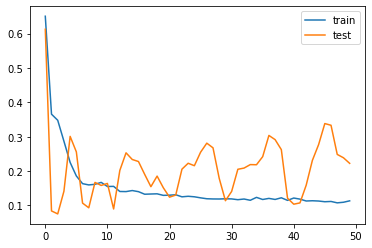

In [43]:
#plotting the training progression
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.show()

In [0]:
#make prediction
yhat=model_lstm.predict(test_X)
xtest=test_X.reshape((test_X.shape[0],test_X.shape[2]))

#invert scaling for forecast
inv_yhat=concatenate((yhat,xtest),axis=1) #inv_yhat=concatenate((yhat,xtest[:,1:]),axis=1)
inv_yhat=scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,0]

#invert scaling for actual
ytest=test_y.reshape((len(test_y),1))
inv_y=concatenate((ytest,xtest),axis=1)#inv_y=concatenate((ytest,xtest[:,1:]),axis=1)
inv_y=scaler.inverse_transform(inv_y)
inv_y=inv_y[:,0]

In [45]:
print("Mean absolute error (MAE):       %f"% mean_absolute_error(inv_y,inv_yhat))
print("Mean squared error (MSE):        %f"% mean_squared_error(inv_y,inv_yhat))
print("Root Mean squared error (RMSE):  %f"% sqrt(mean_squared_error(inv_y,inv_yhat)))
print("R square (R^2):                  %f"% r2_score(inv_y,inv_yhat))

Mean absolute error (MAE):       51.967693
Mean squared error (MSE):        2962.725830
Root Mean squared error (RMSE):  54.430927
R square (R^2):                  -9.152706


<function matplotlib.pyplot.show>

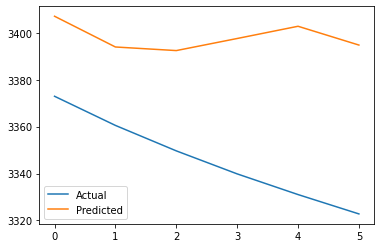

In [46]:
 plt.plot(inv_y,label='Actual')
 plt.plot(inv_yhat,label='Predicted')
 plt.legend()
 plt.show

Agregando semna y meshttps://nbviewer.jupyter.org/github/jbagnato/machine-learning/blob/master/Series_Temporales_Multivariate.ipynb

In [0]:
from sklearn.preprocessing import LabelEncoder
from pandas import concat
from pandas import DataFrame
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense,Activation,Flatten

In [83]:
df = pd.read_csv('Datos_TRM.csv', header=0, index_col=0)

# convert the 'Date' column to datetime format 
df['Date Time']= pd.to_datetime(df['Date Time']) 
  
# Check the format of 'Date' column 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280 entries, 1 to 1280
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date Time    1280 non-null   datetime64[ns]
 1   TRM          1280 non-null   float64       
 2   TRM_logn     1280 non-null   float64       
 3   IBR          1280 non-null   float64       
 4   YTES1Y_COP   1280 non-null   float64       
 5   YTES5Y_COP   1280 non-null   float64       
 6   YTES10Y_COP  1280 non-null   float64       
 7   YTES1Y_UVR   1280 non-null   float64       
 8   YTES5Y_UVR   1280 non-null   float64       
 9   YTES10Y_UVR  1280 non-null   float64       
 10  FF_EfcRate   1280 non-null   float64       
 11  FF_UB        1280 non-null   float64       
 12  WTI_USD      1280 non-null   float64       
 13  GOLD_USD     1280 non-null   float64       
 14  VAR_TRM      1280 non-null   float64       
 15  VAR_LNTRM    1280 non-null   float64       
 16  MM_5  

In [84]:
df.index = df['Date Time']
df.index.name = 'date'
df=df.drop(['Date Time','FF_EfcRate'], axis=1)
df.tail(5)

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
date,,,,,,,,,,,,,,,,
2020-04-24,4020.94,8.299271,0.03706,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,16.94,1735.6,-17.01,-0.004221,4008.944,3990.5985
2020-04-27,4039.87,8.303968,0.03675,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.78,1723.8,18.93,0.004697,4022.306,3988.2750
2020-04-28,4039.83,8.303958,0.03677,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.34,1722.2,-0.04,-0.000010,4036.720,3990.4750
2020-04-29,4046.04,8.305494,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,6.21,0.001536,4036.926,3990.6370
2020-04-30,3983.29,8.289863,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,-62.75,-0.015631,4025.994,3986.5610


In [85]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20,weekday,month
date,,,,,,,,,,,,,,,,,,
2015-01-30,2397.35,7.782119,0.04536,0.045195,0.056178,0.069386,0.004998,0.021237,0.032038,0.25,48.24,1278.5,34.93,0.014677,2382.732,2397.6875,4,1
2015-02-02,2441.10,7.800204,0.04525,0.045092,0.055059,0.068716,0.004537,0.020638,0.031915,0.25,49.57,1276.2,43.75,0.018085,2393.652,2400.1195,0,2
2015-02-03,2407.29,7.786257,0.04523,0.045681,0.055336,0.068560,0.004752,0.021036,0.032218,0.25,53.05,1259.7,-33.81,-0.013947,2397.854,2401.3155,1,2
2015-02-04,2374.72,7.772635,0.04531,0.046289,0.056068,0.069095,0.004712,0.021081,0.032409,0.25,48.45,1263.8,-32.57,-0.013622,2396.576,2399.4105,2,2
2015-02-05,2381.91,7.775658,0.04535,0.046398,0.056269,0.069345,0.004780,0.021430,0.032969,0.25,50.48,1262.0,7.19,0.003023,2400.474,2395.9005,3,2


In [93]:
df.describe()

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20,weekday,month
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,3048.219539,8.018003,0.052413,0.053287,0.063457,0.072009,0.015956,0.027207,0.033723,1.219727,52.163195,1292.769602,1.266305,0.000408,3045.650986,3036.331333,2.065625,6.323437
std,286.087760,0.092594,0.012612,0.009529,0.007822,0.007833,0.006387,0.004965,0.004495,0.798633,10.781998,134.213180,26.957999,0.008568,283.565014,274.227040,1.380215,3.454846
min,2360.580000,7.766663,0.035160,0.038254,0.050234,0.058742,0.004537,0.015435,0.021375,0.250000,-37.630000,1050.800000,-94.370000,-0.030407,2372.094000,2385.795000,0.000000,1.000000
25%,2902.192500,7.973222,0.042540,0.046093,0.058596,0.067309,0.011296,0.024805,0.032274,0.500000,46.437500,1208.050000,-13.947500,-0.004535,2901.454000,2909.559625,1.000000,3.000000
50%,3003.065000,8.007389,0.045170,0.048312,0.061477,0.070298,0.014619,0.027179,0.033740,1.250000,52.295000,1271.450000,0.395000,0.000132,3001.658000,3000.484250,2.000000,6.000000
75%,3194.892500,8.069309,0.062490,0.062428,0.067033,0.075008,0.020063,0.030237,0.035839,2.000000,59.022500,1334.400000,15.520000,0.005170,3190.723500,3200.109625,3.000000,9.000000
max,4153.910000,8.331805,0.077880,0.073609,0.088001,0.096859,0.039636,0.043588,0.045797,2.500000,76.410000,1768.900000,219.020000,0.059307,4110.698000,4031.675000,4.000000,12.000000


In [101]:
dummy=['weekday','month']
df2=df[dummy]
df.shape

(1280, 18)

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [119]:
PASOS=5
# load dataset
values = df.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
#values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
scaled.shape
scale = pd.DataFrame(scaled, index=df.index)
#df['scaled'] = scaled
scaledMerge=pd.concat([df2,scale],axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

[[ 4.          1.         -0.95899248 ... -0.98554873  1.
  -1.        ]
 [ 0.          2.         -0.9102006  ... -0.98259354 -1.
  -0.81818187]
 [ 1.          2.         -0.94790697 ... -0.98114014 -0.5
  -0.81818187]
 ...
 [ 1.          4.          0.87277293 ...  0.94993567 -0.5
  -0.4545455 ]
 [ 2.          4.          0.87969851 ...  0.95013213  0.
  -0.4545455 ]
 [ 3.          4.          0.80971694 ...  0.9451797   0.5
  -0.4545455 ]]


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var12(t-5),var13(t-5),var14(t-5),var15(t-5),var16(t-5),var17(t-5),var18(t-5),var19(t-5),var20(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var16(t-4),var17(t-4),var18(t-4),var19(t-4),var20(t-4),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-06,4.0,1.0,-0.958992,-0.945299,-0.522472,-0.607354,-0.685223,-0.441492,-0.973678,-0.587815,-0.126789,-1.0,0.505963,-0.365827,-0.174830,0.005078,-0.987763,-0.985549,1.0,-1.000000,0.0,2.0,-0.910201,-0.881300,-0.527622,-0.613207,-0.744490,-0.476643,-1.000000,-0.630371,-0.136908,-1.0,0.529288,-0.372232,-0.118542,0.081039,-0.975201,-0.982594,-1.0,-0.818182,...,3.0,2.0,-0.976212,-0.968164,-0.522940,-0.539329,-0.680412,-0.443634,-0.986112,-0.574124,-0.050522,-1.0,0.545247,-0.411781,-0.351862,-0.254731,-0.967353,-0.987720,0.5,-0.818182,4,2,-0.973290,-0.964275,-0.525749,-0.514271,-0.638267,-0.419904,-0.976555,-0.549498,-0.024839,-1.0,0.566468,-0.490043,-0.381027,-0.297619,-0.970303,-0.990745,1.0,-0.818182
2015-02-09,0.0,2.0,-0.910201,-0.881300,-0.527622,-0.613207,-0.744490,-0.476643,-1.000000,-0.630371,-0.136908,-1.0,0.529288,-0.372232,-0.118542,0.081039,-0.975201,-0.982594,-1.0,-0.818182,1.0,2.0,-0.947907,-0.930656,-0.528558,-0.579868,-0.729807,-0.484818,-0.987723,-0.602126,-0.112056,-1.0,0.590319,-0.418187,-0.613517,-0.633051,-0.970367,-0.981140,-0.5,-0.818182,...,4.0,2.0,-0.973290,-0.964275,-0.525749,-0.514271,-0.638267,-0.419904,-0.976555,-0.549498,-0.024839,-1.0,0.566468,-0.490043,-0.381027,-0.297619,-0.970303,-0.990745,1.0,-0.818182,0,2,-0.973034,-0.963934,-0.527622,-0.483509,-0.612819,-0.382332,-0.954198,-0.497214,0.022472,-1.0,0.586987,-0.470826,-0.396279,-0.319975,-0.983265,-0.991976,-1.0,-0.818182
2015-02-10,1.0,2.0,-0.947907,-0.930656,-0.528558,-0.579868,-0.729807,-0.484818,-0.987723,-0.602126,-0.112056,-1.0,0.590319,-0.418187,-0.613517,-0.633051,-0.970367,-0.981140,-0.5,-0.818182,2.0,2.0,-0.984231,-0.978863,-0.524813,-0.545490,-0.691034,-0.456735,-0.989992,-0.598911,-0.096420,-1.0,0.509646,-0.406768,-0.605603,-0.625805,-0.971837,-0.983455,0.0,-0.818182,...,0.0,2.0,-0.973034,-0.963934,-0.527622,-0.483509,-0.612819,-0.382332,-0.954198,-0.497214,0.022472,-1.0,0.586987,-0.470826,-0.396279,-0.319975,-0.983265,-0.991976,-1.0,-0.818182,1,2,-0.988034,-0.983950,-0.527622,-0.488780,-0.580776,-0.345418,-0.937563,-0.463374,0.045532,-1.0,0.537180,-0.496449,-0.483583,-0.448215,-0.991543,-0.994127,-0.5,-0.818182
2015-02-11,2.0,2.0,-0.984231,-0.978863,-0.524813,-0.545490,-0.691034,-0.456735,-0.989992,-0.598911,-0.096420,-1.0,0.509646,-0.406768,-0.605603,-0.625805,-0.971837,-0.983455,0.0,-0.818182,3.0,2.0,-0.976212,-0.968164,-0.522940,-0.539329,-0.680412,-0.443634,-0.986112,-0.574124,-0.050522,-1.0,0.545247,-0.411781,-0.351862,-0.254731,-0.967353,-0.987720,0.5,-0.818182,...,1.0,2.0,-0.988034,-0.983950,-0.527622,-0.488780,-0.580776,-0.345418,-0.937563,-0.463374,0.045532,-1.0,0.537180,-0.496449,-0.483583,-0.448215,-0.991543,-0.994127,-0.5,-0.818182,2,2,-0.977461,-0.969830,-0.527622,-0.502478,-0.584328,-0.309948,-0.954057,-0.506447,-0.000165,-1.0,0.516485,-0.531542,-0.337248,-0.233181,-0.990146,-0.997848,0.0,-0.818182
2015-02-12,3.0,2.0,-0.976212,-0.968164,-0.522940,-0.539329,-0.680412,-0.443634,-0.986112,-0.574124,-0.050522,-1.0,0.545247,-0.411781,-0.351862,-0.254731,-0.967353,-0.987720,0.5,-0.818182,4.0,2.0,-0.973290,-0.964275,-0.525749,-0.514271,-0.638267

In [120]:
#Dividimos en set de Entrenamiento y Validación
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(1275, 118)


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var12(t-5),var13(t-5),var14(t-5),var15(t-5),var16(t-5),var17(t-5),var18(t-5),var19(t-5),var20(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var16(t-4),var17(t-4),var18(t-4),var19(t-4),var20(t-4),...,var19(t-2),var20(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-06,4.0,1.0,-0.958992,-0.945299,-0.522472,-0.607354,-0.685223,-0.441492,-0.973678,-0.587815,-0.126789,-1.0,0.505963,-0.365827,-0.174830,0.005078,-0.987763,-0.985549,1.0,-1.000000,0.0,2.0,-0.910201,-0.881300,-0.527622,-0.613207,-0.744490,-0.476643,-1.000000,-0.630371,-0.136908,-1.0,0.529288,-0.372232,-0.118542,0.081039,-0.975201,-0.982594,-1.0,-0.818182,...,0.0,-0.818182,3.0,2.0,-0.976212,-0.968164,-0.522940,-0.539329,-0.680412,-0.443634,-0.986112,-0.574124,-0.050522,-1.0,0.545247,-0.411781,-0.351862,-0.254731,-0.967353,-0.987720,0.5,-0.818182,-0.973290,-0.964275,-0.525749,-0.514271,-0.638267,-0.419904,-0.976555,-0.549498,-0.024839,-1.0,0.566468,-0.490043,-0.381027,-0.297619,-0.970303,-0.990745,1.0,-0.818182
2015-02-09,0.0,2.0,-0.910201,-0.881300,-0.527622,-0.613207,-0.744490,-0.476643,-1.000000,-0.630371,-0.136908,-1.0,0.529288,-0.372232,-0.118542,0.081039,-0.975201,-0.982594,-1.0,-0.818182,1.0,2.0,-0.947907,-0.930656,-0.528558,-0.579868,-0.729807,-0.484818,-0.987723,-0.602126,-0.112056,-1.0,0.590319,-0.418187,-0.613517,-0.633051,-0.970367,-0.981140,-0.5,-0.818182,...,0.5,-0.818182,4.0,2.0,-0.973290,-0.964275,-0.525749,-0.514271,-0.638267,-0.419904,-0.976555,-0.549498,-0.024839,-1.0,0.566468,-0.490043,-0.381027,-0.297619,-0.970303,-0.990745,1.0,-0.818182,-0.973034,-0.963934,-0.527622,-0.483509,-0.612819,-0.382332,-0.954198,-0.497214,0.022472,-1.0,0.586987,-0.470826,-0.396279,-0.319975,-0.983265,-0.991976,-1.0,-0.818182
2015-02-10,1.0,2.0,-0.947907,-0.930656,-0.528558,-0.579868,-0.729807,-0.484818,-0.987723,-0.602126,-0.112056,-1.0,0.590319,-0.418187,-0.613517,-0.633051,-0.970367,-0.981140,-0.5,-0.818182,2.0,2.0,-0.984231,-0.978863,-0.524813,-0.545490,-0.691034,-0.456735,-0.989992,-0.598911,-0.096420,-1.0,0.509646,-0.406768,-0.605603,-0.625805,-0.971837,-0.983455,0.0,-0.818182,...,1.0,-0.818182,0.0,2.0,-0.973034,-0.963934,-0.527622,-0.483509,-0.612819,-0.382332,-0.954198,-0.497214,0.022472,-1.0,0.586987,-0.470826,-0.396279,-0.319975,-0.983265,-0.991976,-1.0,-0.818182,-0.988034,-0.983950,-0.527622,-0.488780,-0.580776,-0.345418,-0.937563,-0.463374,0.045532,-1.0,0.537180,-0.496449,-0.483583,-0.448215,-0.991543,-0.994127,-0.5,-0.818182
2015-02-11,2.0,2.0,-0.984231,-0.978863,-0.524813,-0.545490,-0.691034,-0.456735,-0.989992,-0.598911,-0.096420,-1.0,0.509646,-0.406768,-0.605603,-0.625805,-0.971837,-0.983455,0.0,-0.818182,3.0,2.0,-0.976212,-0.968164,-0.522940,-0.539329,-0.680412,-0.443634,-0.986112,-0.574124,-0.050522,-1.0,0.545247,-0.411781,-0.351862,-0.254731,-0.967353,-0.987720,0.5,-0.818182,...,-1.0,-0.818182,1.0,2.0,-0.988034,-0.983950,-0.527622,-0.488780,-0.580776,-0.345418,-0.937563,-0.463374,0.045532,-1.0,0.537180,-0.496449,-0.483583,-0.448215,-0.991543,-0.994127,-0.5,-0.818182,-0.977461,-0.969830,-0.527622,-0.502478,-0.584328,-0.309948,-0.954057,-0.506447,-0.000165,-1.0,0.516485,-0.531542,-0.337248,-0.233181,-0.990146,-0.997848,0.0,-0.818182
2015-02-12,3.0,2.0,-0.976212,-0.968164,-0.522940,-0.539329,-0.680412,-0.443634,-0.986112,-0.574124,-0.050522,-1.0,0.545247,-0.411781,-0.351862,-0.254731,-0.967353,-0.987720,0.5,-0.818182,4.0,2.0,-0

In [139]:
# split into train and test sets
values = newReframed.values
n_train_days = 1198- (76+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1117, 1, 117) (1117,) (158, 1, 117) (158,)


In [0]:
def crear_modeloFF():
    model = Sequential() 
    #tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [141]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1, 5)              80        
_________________________________________________________________
flatten_2 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


ValueError: ignored

Epoch 1/50
14/14 - 0s - loss: 0.7171 - val_loss: 1.6828
Epoch 2/50
14/14 - 0s - loss: 0.6162 - val_loss: 1.6759
Epoch 3/50
14/14 - 0s - loss: 0.5430 - val_loss: 1.6461
Epoch 4/50
14/14 - 0s - loss: 0.4833 - val_loss: 1.5899
Epoch 5/50
14/14 - 0s - loss: 0.4297 - val_loss: 1.5071
Epoch 6/50
14/14 - 0s - loss: 0.3780 - val_loss: 1.4022
Epoch 7/50
14/14 - 0s - loss: 0.3269 - val_loss: 1.2840
Epoch 8/50
14/14 - 0s - loss: 0.2771 - val_loss: 1.1559
Epoch 9/50
14/14 - 0s - loss: 0.2348 - val_loss: 1.0184
Epoch 10/50
14/14 - 0s - loss: 0.2021 - val_loss: 0.8899
Epoch 11/50
14/14 - 0s - loss: 0.1844 - val_loss: 0.8266
Epoch 12/50
14/14 - 0s - loss: 0.1771 - val_loss: 0.8164
Epoch 13/50
14/14 - 0s - loss: 0.1731 - val_loss: 0.8333
Epoch 14/50
14/14 - 0s - loss: 0.1710 - val_loss: 0.8362
Epoch 15/50
14/14 - 0s - loss: 0.1691 - val_loss: 0.8464
Epoch 16/50
14/14 - 0s - loss: 0.1677 - val_loss: 0.8487
Epoch 17/50
14/14 - 0s - loss: 0.1666 - val_loss: 0.8488
Epoch 18/50
14/14 - 0s - loss: 0.1654 - 

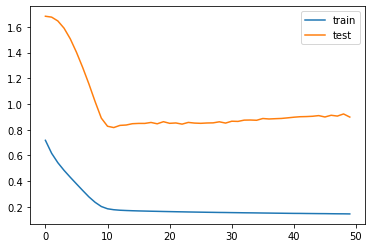

ValueError: ignored

In [138]:
 
# design network
model = Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [104]:
values = df.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 2
n_features = 17
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
 

NameError: ignored